In [4]:
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.Random import get_random_bytes

def hybrid_rsa_aes_encryption(data, public_key):
    # Generate a random AES key
    aes_key = get_random_bytes(16)

    # Encrypt the data with AES
    cipher_aes = AES.new(aes_key, AES.MODE_EAX)
    ciphertext, tag = cipher_aes.encrypt_and_digest(data)

    # Encrypt the AES key with RSA
    cipher_rsa = PKCS1_OAEP.new(public_key)
    cipher_key = cipher_rsa.encrypt(aes_key)

    return (ciphertext, tag, cipher_aes.nonce, cipher_key)

def hybrid_rsa_aes_decryption(ciphertext, tag, nonce, cipher_key, private_key):
    # Decrypt the AES key with RSA
    cipher_rsa = PKCS1_OAEP.new(private_key)
    aes_key = cipher_rsa.decrypt(cipher_key)

    # Decrypt the data with AES
    cipher_aes = AES.new(aes_key, AES.MODE_EAX, nonce=nonce)
    data = cipher_aes.decrypt_and_verify(ciphertext, tag)

    return data


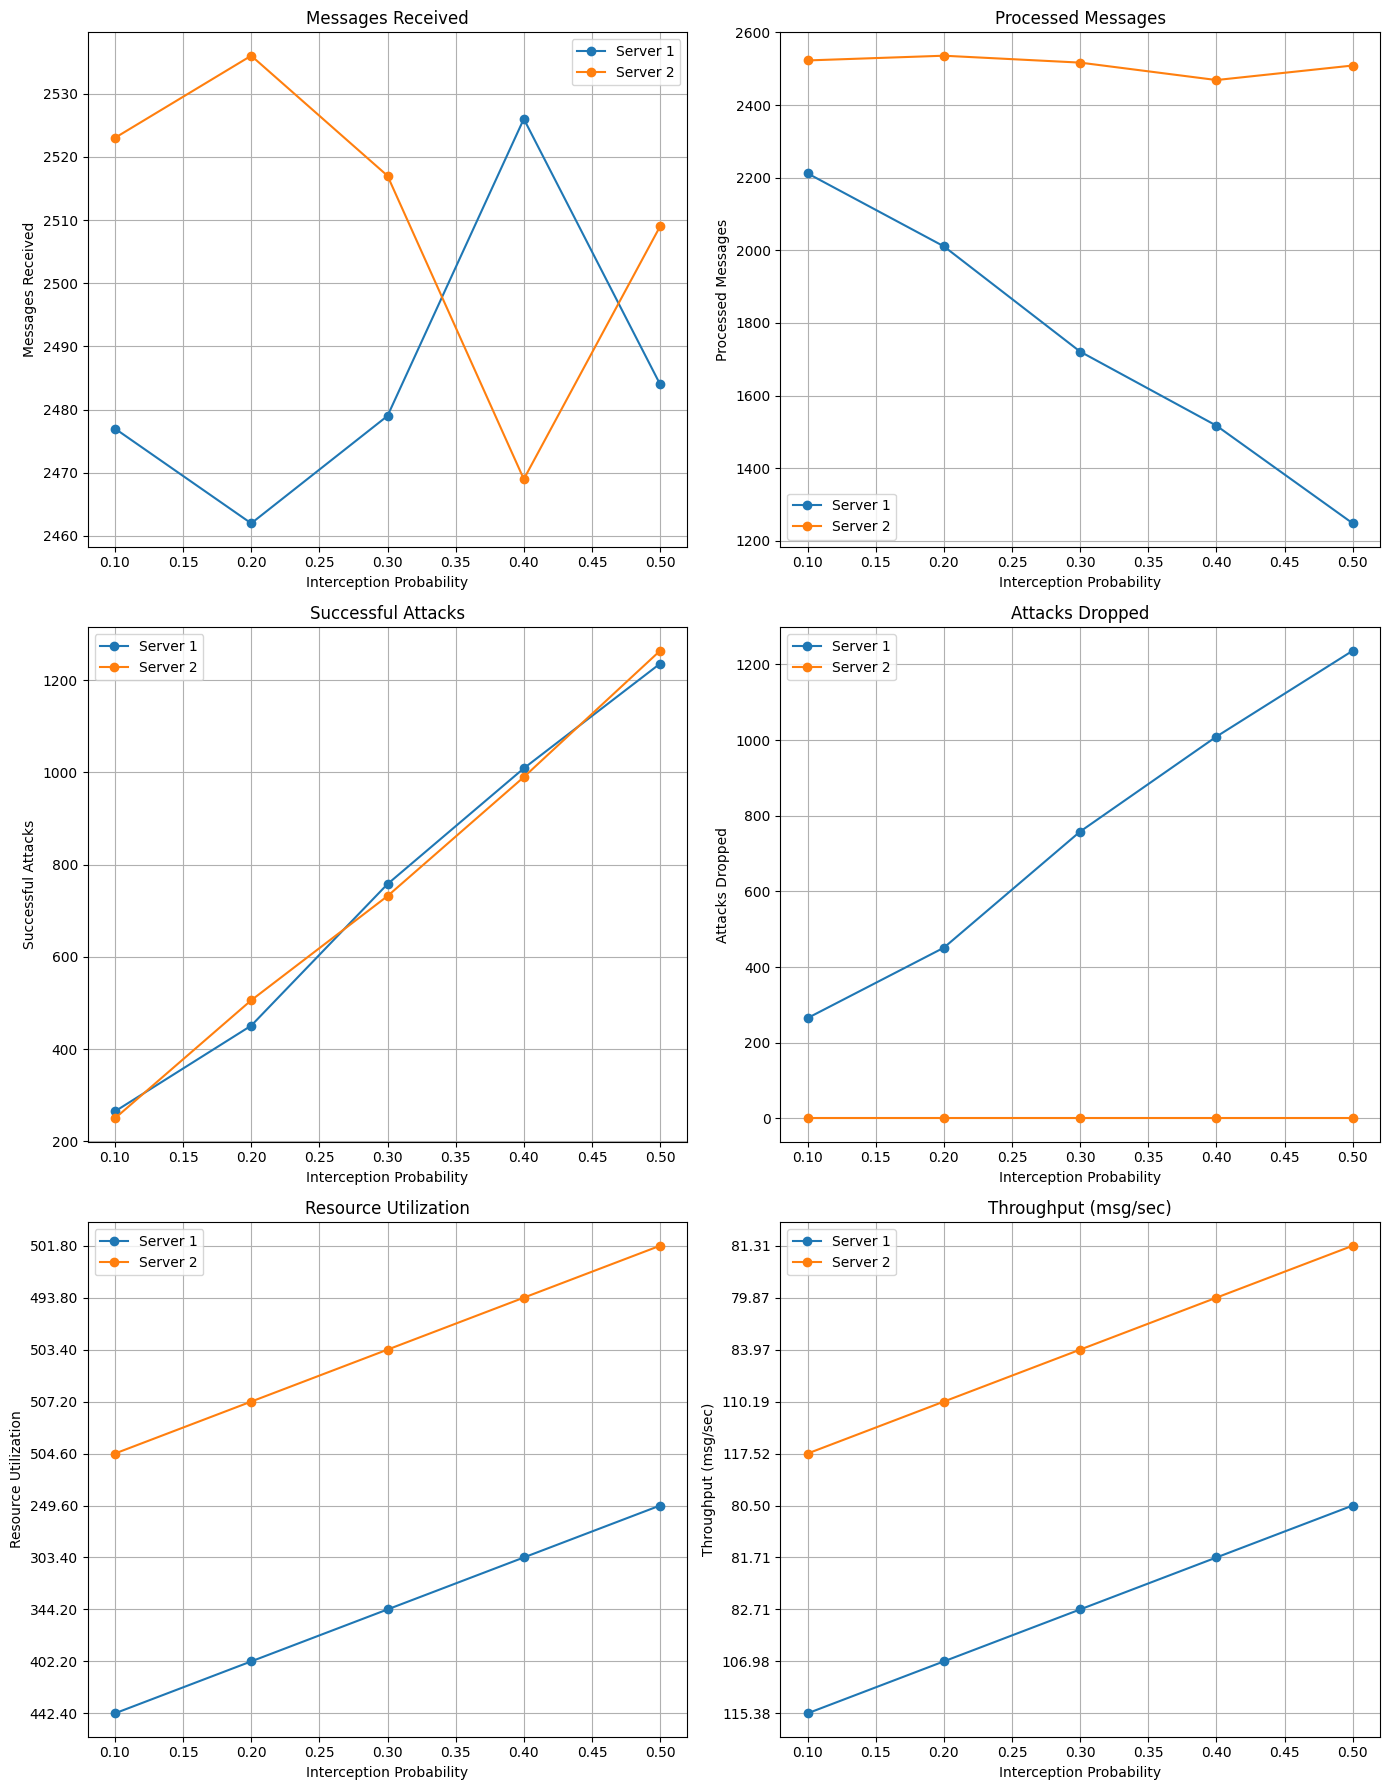

In [17]:
import random
import time
import threading
import pandas as pd
import matplotlib.pyplot as plt
from Crypto.PublicKey import RSA

private_key = RSA.generate(2048)
public_key = private_key.publickey()

class Sensor:
    def __init__(self, sensor_id):
        self.sensor_id = sensor_id

    def generate_message(self):
        timestamp = time.time()
        data = random.randint(1, 100)
        return {'sensor_id': self.sensor_id, 'timestamp': timestamp, 'data': data, 'send_timestamp': timestamp}

    def encrypt_message(self):
        message = self.generate_message()
        serialized_message = str(message).encode('utf-8')
        encrypted_message = hybrid_rsa_aes_encryption(serialized_message, public_key)
        return encrypted_message

class Attacker:
    def __init__(self, attacker_id, servers):
        self.attacker_id = attacker_id
        self.servers = servers

    def intercept_message(self, message, sender):
        # The attacker intercepts the message
        intercepted_message = message
        # The attacker resends the intercepted message to a random server
        target_server = random.choice(self.servers)
        target_server.process_message(intercepted_message, f"Attacker {self.attacker_id}")

class Server:
    def __init__(self, server_id, private_key):
        self.server_id = server_id
        self.private_key = private_key
        self.received_messages = set()
        self.successful_messages = 0
        self.successful_attacks = 0
        self.successful_attacks_dropped = 0
        self.start_time = time.time()
        self.end_time = None
        self.processing_units_used = 0 
        self.processed_messages = 0  

    def process_message(self, message, sender):
        decrypted_message = hybrid_rsa_aes_decryption(*message, self.private_key)
        original_message = decrypted_message.decode('utf-8')
        
        timestamp = eval(original_message)['timestamp']
        if (timestamp, sender) not in self.received_messages:
            self.received_messages.add((timestamp, sender))
            self.successful_messages += 1

            if "Attacker" in sender:
                self.successful_attacks += 1

            if self.server_id == 1 and "Attacker" in sender:
                self.successful_attacks_dropped += 1
            else:
                self.processed_messages += 1
                self.processing_units_used += 0.2
                #print(f"Server {self.server_id} received: {original_message} from {sender}")

    def calculate_throughput(self):
        total_time = self.end_time - self.start_time if self.end_time else time.time() - self.start_time
        return self.successful_messages / total_time


    def calculate_resource_utilization(self):
        return self.processing_units_used

def simulate_sensor(sensor, servers, attackers, interception_probability):
    for _ in range(100):
        target_server = random.choice(servers)
        encrypted_message = sensor.encrypt_message()
        #print(f"Sensor {sensor.sensor_id} sending: {encrypted_message}")

        if random.random() < interception_probability:  # Dynamic interception chance
            attacker = random.choice(attackers)
            attacker.intercept_message(encrypted_message, f"Sensor {sensor.sensor_id}")
        else:
            target_server.process_message(encrypted_message, f"Sensor {sensor.sensor_id}")


def compile_metrics_to_dataframe(servers, interception_probability):
    # Initialize an empty list to hold the data for each server
    data = []

    # Compile metrics for each server
    for server in servers:
        resource_utilization = server.calculate_resource_utilization()
        throughput = server.calculate_throughput()
        
        # Add the server's metrics to the data list
        data.append({
            'Interception Probability': interception_probability,
            'Server ID': server.server_id,
            'Messages Received': server.successful_messages,
            'Processed Messages': server.processed_messages,
            'Successful Attacks': server.successful_attacks,
            'Attacks Dropped': server.successful_attacks_dropped,
            'Resource Utilization': f"{resource_utilization:.2f}",
            'Throughput (msg/sec)': f"{throughput:.2f}"
        })

    # Convert the list of data into a pandas DataFrame
    return pd.DataFrame(data)

def main():
    interception_probabilities = [0.1, 0.2, 0.3, 0.4, 0.5]
    metrics_list = []  # Collect data as a list of dictionaries

    for interception_probability in interception_probabilities:
        # Initialize or reset sensors, servers, and attackers for each probability run
        sensors = [Sensor(sensor_id) for sensor_id in range(1, 51)]
        servers = [Server(server_id, private_key) for server_id in range(1, 3)]
        attackers = [Attacker(attacker_id, servers) for attacker_id in range(1, 6)]
        
        threads = []
        for sensor in sensors:
            thread = threading.Thread(target=simulate_sensor, args=(sensor, servers, attackers, interception_probability))
            threads.append(thread)
            thread.start()
        
        for thread in threads:
            thread.join()
        
        # Compile metrics for this interception probability
        metrics_df = compile_metrics_to_dataframe(servers, interception_probability)
        
        # Convert each row in the metrics DataFrame to a dictionary and add it to the list
        for _, row in metrics_df.iterrows():
            metrics_list.append(row.to_dict())
    
    # Convert the list of dictionaries to a DataFrame
    final_metrics_df = pd.DataFrame(metrics_list)
    
    server_ids = final_metrics_df['Server ID'].unique()

    # Setup the plot
    fig, axs = plt.subplots(3, 2, figsize=(14, 18))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust space between plots

    # Metrics to be plotted
    metrics_to_plot = ['Messages Received', 'Processed Messages', 'Successful Attacks', 'Attacks Dropped', 'Resource Utilization', 'Throughput (msg/sec)']

    # Iterate over each subplot and metric
    for ax, metric in zip(axs.flat, metrics_to_plot):
        for server_id in server_ids:
            # Select data for the current server
            subset = final_metrics_df[final_metrics_df['Server ID'] == server_id]
            # Plot data
            ax.plot(subset['Interception Probability'], subset[metric], marker='o', linestyle='-', label=f'Server {server_id}')
        
        # Set plot titles and labels
        ax.set_title(metric)
        ax.set_xlabel('Interception Probability')
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.legend(loc='best')  # Adjust legend placement

    plt.tight_layout()
    plt.show()

    # Display the final DataFrame
    #print(final_metrics_df)

if __name__ == "__main__":
    main()